## Loading of Steinmetz data

includes some visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains <u>39 sessions</u> from <u>10 mice</u>, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins. `shape: (neurons, trials, time)`
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording **when the mouse was no longer engaged** and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

# Helper functions and lists

In [ ]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

In [ ]:
def get_dat(num=11):
  return alldat[num] # one dataset is one mouse

In [ ]:
for dataset in range(39):
  print(get_dat(dataset)['mouse_name'])

Cori
Cori
Cori
Forssmann
Forssmann
Forssmann
Forssmann
Hench
Hench
Hench
Hench
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Moniz
Moniz
Moniz
Muller
Muller
Muller
Radnitz
Radnitz
Radnitz
Radnitz
Radnitz
Richards
Richards
Richards
Richards
Richards
Tatum
Tatum
Tatum
Tatum
Theiler


# "What" - analyses of the raw data (plots)

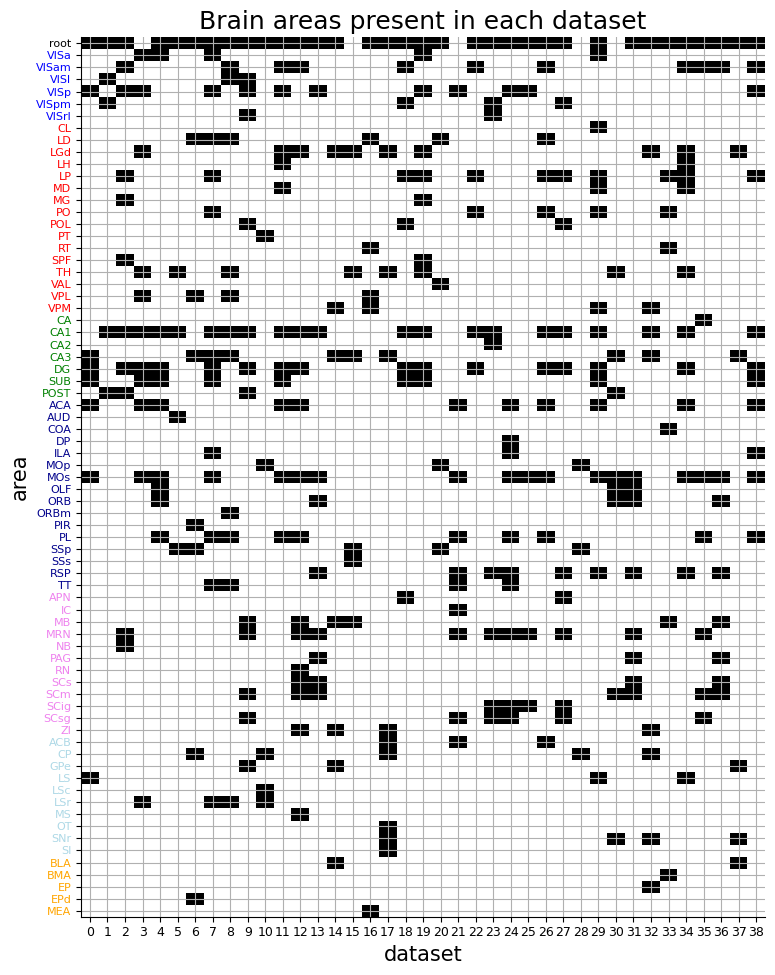

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex


# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


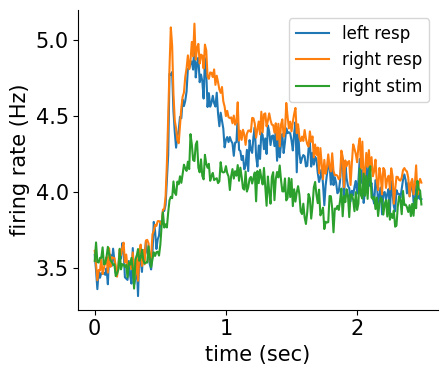

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

In [ ]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

NameError: ignored

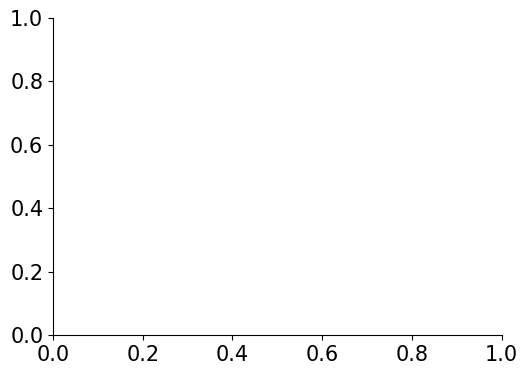

In [ ]:
# @title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)

  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.show()

In [ ]:
# @title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])
  if np.sum(barea == j) == 0:
    continue
  plt.plot(1/dt * dat['spks'][barea == j][:, response < 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response > 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response == 0].mean(axis=(0, 1)))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel='time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# @title top PC directions from stimulus + response period, with projections of the entire duration

droll = np.reshape(dat['spks'][:, :, 51:130], (NN, -1))  # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
# @title The top PCs capture most variance across the brain. What do they care about?
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2, len(pc_10ms) + 1, j + 1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2, len(pc_10ms) + 1, len(pc_10ms) + 1 + j + 1)

  plt.plot(pc1[response > 0, :].mean(axis=0))
  plt.plot(pc1[response < 0, :].mean(axis=0))
  plt.plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)
plt.show()

In [ ]:
# @title now sort all trials by response latency and see if the PCs care about that.
isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time', ylabel='trials sorted by latency')
  plt.title('PC %d'%j)
plt.show()

In [ ]:
# @title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response) == np.sign(vis_left - vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10)

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time')
  if j == 0:
    ax.set(ylabel='trials sorted by latency')
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')
plt.show()

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel='binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1, 5, 2)
plt.plot(dat['wheel'][0, response > 0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Left choices')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Right choices')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='No go choices')
plt.show()

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])

  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p == 0)].mean(axis=(0, 1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j == 0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)

# Linear Decoder

## Import

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate
from scipy import stats
import matplotlib.patches as mpatches

## Helper functions

In [ ]:
# Old Group brain areas by brain region

brain_region_dict = old_brain_region_dict = {
    "visual cortex": ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],
    "thalamus": ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],
    "hippocampus": ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],
    "non-visual cortex": ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],
    "midbrain": ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],
    "basal ganglia": ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],
    "cortical subplate": ["BLA", "BMA", "EP", "EPd", "MEA"],
    "other": ["other"]
}


In [ ]:
# Group brain areas by brain region
new_brain_region_dict = {
    "anterior visual cortex": ["VISa", "VISam"],
    "lateral visual cortex": ["VISl"],
    "posterior visual cortex": ["VISp", "VISpm", "VISrl"],
    "thalamus": ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],
    "hippocampus": ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],
    #"non-visual cortex": ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],
    "anterior cingulum": ["ACA"],
    "auditory cortex": ["AUD"],
    "olfactory cortex": ["OLF"],
    "primary motor area": ["MOp"],
    "secundary motor area": ["MOs"],
    "orbitofrontal cortex": ["ORB", "ORBm"],
    "somatosensory area": ["SSp", "SSs"],
    "temporal area": ["TT"],
    "limbic areas": ["ILA", "PL"],
    "midbrain": ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],
    "basal ganglia": ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],
    "cortical subplate": ["BLA", "BMA", "EP", "EPd", "MEA"],
    "other": ["other"]
}

In [ ]:
# Group ALL brain areas

all_brain_areas = {
    "all areas": ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"] + ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"] + ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"] + ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"] + ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"] + ["BLA", "BMA", "EP", "EPd", "MEA"] + ["other"]
}


visual cortex:

1. VISa: Anterior visual area
2. VISam: Anteromedial visual area
3. VISl: Lateral visual area
4. VISp: Posterior visual area
5. VISpm: Posteromedial visual area
6. VISrl: Rostral lateral visual area

thalamus:

* CL: Central lateral nucleus
* LD: Lateral dorsal nucleus
* LGd: Dorsal lateral geniculate nucleus
* LH: Lateral habenula
* LP: Lateral posterior nucleus
* MD: Mediodorsal nucleus
* MG: Medial geniculate nucleus
* PO: Posterior nuclear group
* POL: Posterior thalamic nuclear group
* PT: Pretectal nucleus
* RT: Reticular nucleus
* SPF: Subparafascicular nucleus
* TH: Thalamus
* VAL: Ventral anterior nucleus
* VPL: Ventral posterolateral nucleus
* VPM: Ventral posteromedial nucleus


non-visual cortex:

* ACA: Anterior cingulate area
* AUD: Auditory area
* COA: Cortical amygdalar area
* DP: Dorsal peduncular area
* ILA: Infralimbic area
* MOp: Primary motor area
* MOs: Secondary motor area
* OLF: Olfactory area
* ORB: Orbital area
* ORBm: Orbital medial area
* PIR: Piriform area
* PL: Prelimbic area
* SSp: Primary somatosensory area
* SSs: Secondary somatosensory area
* RSP: Retrosplenial area
* TT: Temporal area

cortical subplate:

- BLA: Basolateral amygdala
- BMA: Basomedial amygdala
- EP: Endopiriform nucleus
- EPd: Dorsal endopiriform nucleus
- MEA: Medial entorhinal cortex

In [ ]:
def time_binning(data, dt, time_window):
  """
  Update time bins of spikes data by time_window

  Params:
    data: spikes data
    dt: nothing (just to not interact with the other time_binning function)
    time_window: How many time points will be in the new bin
  """

  # Init params
  #time_window = time_window/dt
  neurons =     data.shape[0]
  trials  =     data.shape[1]
  n_bins  = int(data.shape[2]/time_window)

  # Init new data
  binned_data = np.zeros((neurons, trials, n_bins))

  # Sum the spikes in a bin in every time bin
  for i in range(n_bins):
    binned_data[:,:,i] = np.sum(data[:,:,i*time_window:(i+1)*time_window],axis=2)

  return binned_data

#rebinned_spikes = time_binning(dat['spks'],_,5)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing

In [ ]:
# Variables to decode from neural activity

variables = {
            #'wheel': 'int',
            #'pupil': 'real',
            'response': 'bin',
            #'response_time': 'real',
            #'contrast_right': 'real',
            #'contrast_left': 'real',
            'feedback_type': 'bin'
            #'prev_reward': 'real',
            #'cellid_orig': 'bool',
            #'reaction_time': 'real',
            #'face': 'real',
            #'licks': 'real',
            #'prev_reward': 'real' # why real?
            }

# notabene: active_trials, spks, brain_area, mouse_name

In [ ]:
def logistic_regression(X, y, calculate_coeffs=False, solver='sag', cv=5):

  #print(X.shape)
  #print(y.shape)
  n_neurons = X.shape[1]

  # Init model
  lr = LogisticRegression(solver=solver)

  # Calculate accuracy
  score = cross_validate(lr, X, y, cv=cv, return_train_score=True,
                         return_estimator=True)

  # Results
  test_mean = np.mean(score['test_score'])
  score_test = score['test_score']
  score_train = score['train_score']
  coeffs = None
  if calculate_coeffs:
    coeffs = np.zeros((cv, n_neurons, len(variables)))
    for cnt, model in enumerate(score['estimator']):
      coeffs[cnt,:] = model.coef_.reshape(2, 1)

  return {
      'test accuracy': score_test,
      'train accuracy': score_train,
      'coeffs': coeffs
  }

In [ ]:
def split_data(data, expvar):
  """
  Split data by a variable (expvar)

  Params:
    data: spks
    expvar: experience variable
    split data along a expvar (e.g. brain areas)

  Return:
    dict containing the splitted parts of data.
  """

  # Init dict
  splitted_data = {}

  print(expvar[0], np.unique(expvar)[0], expvar[0] == np.unique(expvar)[0])
  for variable in np.unique(expvar):

    # Specify which neurons accords to the variable
    which = [True if x==variable else False for x in expvar]

    # Get the right part of the data
    new_data = np.array(data[which,:,:])

    # Update dict
    splitted_data[variable] = new_data

  return splitted_data

In [ ]:
# Filter out e.g. the no-response active trials (in that case to be a boolean)

def trial_filter(dat, which_trials):
  """
  Use only the relevant trials in the data

  Params:
    dat: one session from the steinmetz data
    which_trials: bool array for masking
  """

  # Init filtered dat
  fdat = {}
  #print(dat['response'][which_trials].shape)

  # Use only the which_trials from the olda data
  fdat['spks'] = dat['spks'][:,which_trials,:]
  fdat['response'] = dat['response'][which_trials]
  fdat['contrast_right'] = dat['contrast_right'][which_trials]
  fdat['contrast_left'] = dat['contrast_left'][which_trials]
  #dat['wheel'] = dat['wheel'][:,which_trials,:]
  fdat['feedback_type'] = dat['feedback_type'][which_trials]
  fdat['prev_reward'] = dat['prev_reward'][which_trials,:]
  fdat['brain_area'] = dat['brain_area']

  print('WARNING! transformd only variables: spks, response, contrast_right, contrast_left, feedback_type', 'prev_reward')

  return fdat

In [ ]:
def merge_brain_areas(brain_areas:list, dict_of_areas:dict):
  """
  Merge brain areas (brain_areas) according to a dictionary of areas to be merged(dict_of_areas)
  """

  # Reverse dict_of_areas and init new list of brain regions
  reversed_dict_of_areas = {}
  brain_regions = []

  # Make the reverse dictionary of brain_areas
  for region, areas_of_a_region in dict_of_areas.items():
    for area in areas_of_a_region:
      reversed_dict_of_areas[area] = region
  reversed_dict_of_areas['root'] = 'root'

  # Make the new list with the brain regions of the neurons
  for area_of_neuron in brain_areas:
    brain_regions.append(reversed_dict_of_areas[area_of_neuron])

  return brain_regions

## Plotting functions

In [ ]:
def plot_accuracy(ax, accuracy, dt=10, chance_level=.5, color=None, name=None):
  """
  dt: time window (bin size)
  """

  time_length = 2500
  x = np.arange(0,time_length,dt)

  # Calculate mean and SEM
  mean = np.mean(accuracy, axis=0)
  SEM = 2*stats.sem(accuracy, axis=0)

  #data_length = mean.shape[0]

  # Init plot
  ax.set_title(name)
  plt.sca(ax)
  plt.ylim([0,1.05])
  plt.axvline(500, label="Mean neuron")

  # Plot chance level, mean, and SEM
  plt.plot([0,time_length],[chance_level,chance_level])
  plt.plot(x, mean, color=color, label=name)
  plt.fill_between(x, mean-SEM, mean+SEM, color=color, alpha=.1)

## Decoder

In [ ]:

def decoder(ax:list, data, dict_of_labels, keys, dt=10, cv=5, brain_area=None):
  """
  Decodes multiple variables (keys of dict_of_labels) in every timepoint

  Params:
    ax: list of axis to plot on. must be the same length as variables
    data: neural activity
    variables: to decode

  Return:
    accuracies of the decoding. Shape: (cv, time length of the trial)
  """
  time = data.shape[2]

  accuracies = {}
  coeffs = {}

  for cnt, key in enumerate(keys):

    variable = dict_of_labels[key]

    # Reshape the data to be the same shape
    if variable.shape[0] == 1:
      variable = variable.squeeze()
    if variable.ndim == 1:
      variable = np.repeat(np.expand_dims(variable, axis=1), time, axis=1)
    if variable.shape[1] == 1:
      variable = np.repeat(variable, time, axis=1)

    print('data.shape',data.shape)
    print('variable.shape', variable.shape)

    # Decode in each timepoint
    accuracy = np.zeros((cv, time))
    coeff = np.zeros((cv, time))
    for t in range(time):
      result = logistic_regression(data[:,:,t].T, variable[:,t], cv=cv)['test accuracy']
      accuracy[:,t] = result
      result_coeffs = logistic_regression(data[:,:,t].T, variable[:,t], cv=cv)['coeffs']
      coeff[:,t] = result_coeffs

    # Plot
    plot_accuracy(ax[cnt], accuracy, dt=dt, name=f'{brain_area} {key}')

    # Save accuracy
    accuracies[key] = accuracy
    #Save coeff
    coeffs[key] = coeff

  return accuracies, coeffs

In [ ]:
variable = np.zeros((340))
time = 250

variable = np.repeat(np.expand_dims(variable, axis=1), time, axis=1)

print(variable.shape)

(340, 250)


In [ ]:
def time_points(time_length, dt):
  return np.arange(0,time_length,dt)

In [ ]:
dat = get_dat()
which = dat['response'] !=0
new = dat['response'][which]
len(new)

276

WARNING! transformd only variables: spks, response, contrast_right, contrast_left, feedback_type prev_reward
VISp ACA False
ACA
data.shape (16, 340, 50)
variable.shape (340, 50)
data.shape (16, 340, 50)
variable.shape (340, 50)
CA1
data.shape (50, 340, 50)
variable.shape (340, 50)
data.shape (50, 340, 50)
variable.shape (340, 50)
DG
data.shape (65, 340, 50)
variable.shape (340, 50)
data.shape (65, 340, 50)
variable.shape (340, 50)
LGd
data.shape (11, 340, 50)
variable.shape (340, 50)
data.shape (11, 340, 50)
variable.shape (340, 50)
LH
data.shape (18, 340, 50)
variable.shape (340, 50)
data.shape (18, 340, 50)
variable.shape (340, 50)
MD
data.shape (126, 340, 50)
variable.shape (340, 50)
data.shape (126, 340, 50)
variable.shape (340, 50)
MOs
data.shape (6, 340, 50)
variable.shape (340, 50)
data.shape (6, 340, 50)
variable.shape (340, 50)
PL
data.shape (56, 340, 50)
variable.shape (340, 50)
data.shape (56, 340, 50)
variable.shape (340, 50)
SUB
data.shape (105, 340, 50)
variable.shape (34

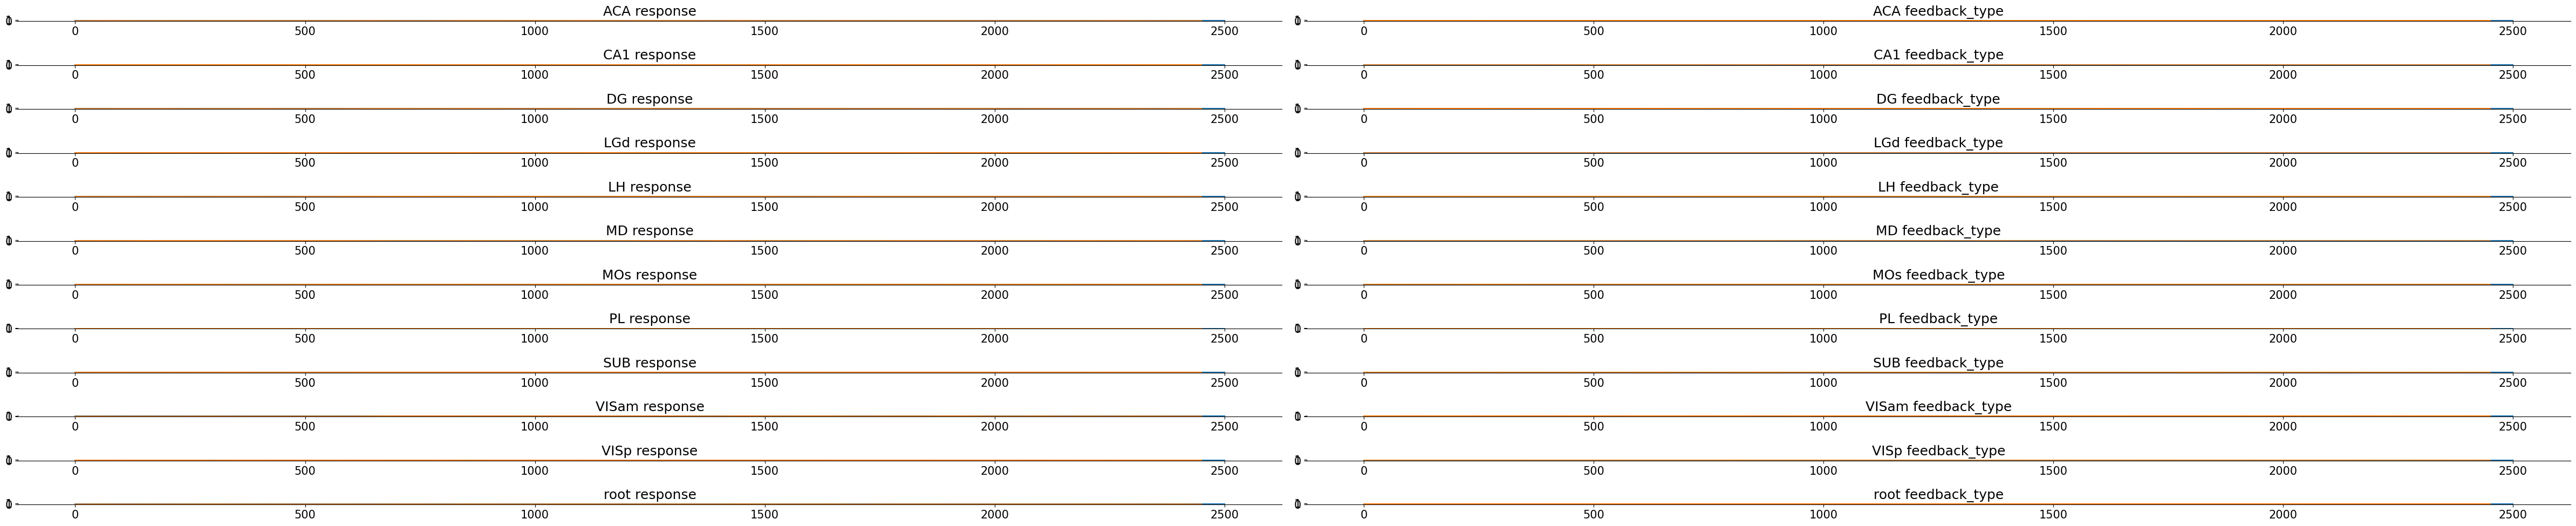

In [ ]:
######################################################################################################################################
### Decode variables from brain regions in one session -> plot and save to all_accuracies (save for a better plot in a later cell) ###
######################################################################################################################################

bin_size = 50
dt=10

# Get data
dat = get_dat()

# No-response filtering
trial_filter(dat, dat['response']!=0)

# Time binning
#rebinned_spikes = time_binning(dat['spks'],np.arange(2500),bin_size)
rebinned_spikes = time_binning(dat['spks'],0,int(bin_size/dt))
dt=bin_size # update its value

# Split data along brain_areas
spks = split_data(rebinned_spikes,dat['brain_area'])

# Init sizes
n_brain_areas = np.unique(dat['brain_area']).shape[0]
n_variables = len(variables)

# Init plot
fig, axs = plt.subplots(nrows=n_brain_areas, ncols=n_variables, figsize=(n_brain_areas*4,n_variables*5))

all_accuracies = {}

for cnt, brain_area in enumerate(np.unique(dat['brain_area'])):
  print(brain_area)

  accuracies = decoder(axs[cnt,:], spks[brain_area], dat, variables, dt=bin_size, brain_area=brain_area, cv=5)

  all_accuracies[brain_area] = accuracies

In [ ]:
['wdf', 'sv', 'wdf'] == 'wdf'

False

WARNING! transformd only variables: spks, response, contrast_right, contrast_left, feedback_type prev_reward
rebinned_spikes shape: (1070, 157, 50)
rebinned_spikes shape: (1070, 157, 50)
hippocampus hippocampus True
hippocampus
spks[brain_region].shape (381, 157, 50)
data.shape (381, 157, 50)
variable.shape (157, 50)
data.shape (381, 157, 50)
variable.shape (157, 50)
lateral visual cortex
spks[brain_region].shape (231, 157, 50)
data.shape (231, 157, 50)
variable.shape (157, 50)
data.shape (231, 157, 50)
variable.shape (157, 50)
posterior visual cortex
spks[brain_region].shape (302, 157, 50)
data.shape (302, 157, 50)
variable.shape (157, 50)
data.shape (302, 157, 50)
variable.shape (157, 50)
root
spks[brain_region].shape (156, 157, 50)
data.shape (156, 157, 50)
variable.shape (157, 50)
data.shape (156, 157, 50)
variable.shape (157, 50)
WARNING! transformd only variables: spks, response, contrast_right, contrast_left, feedback_type prev_reward
rebinned_spikes shape: (619, 151, 50)
rebinn

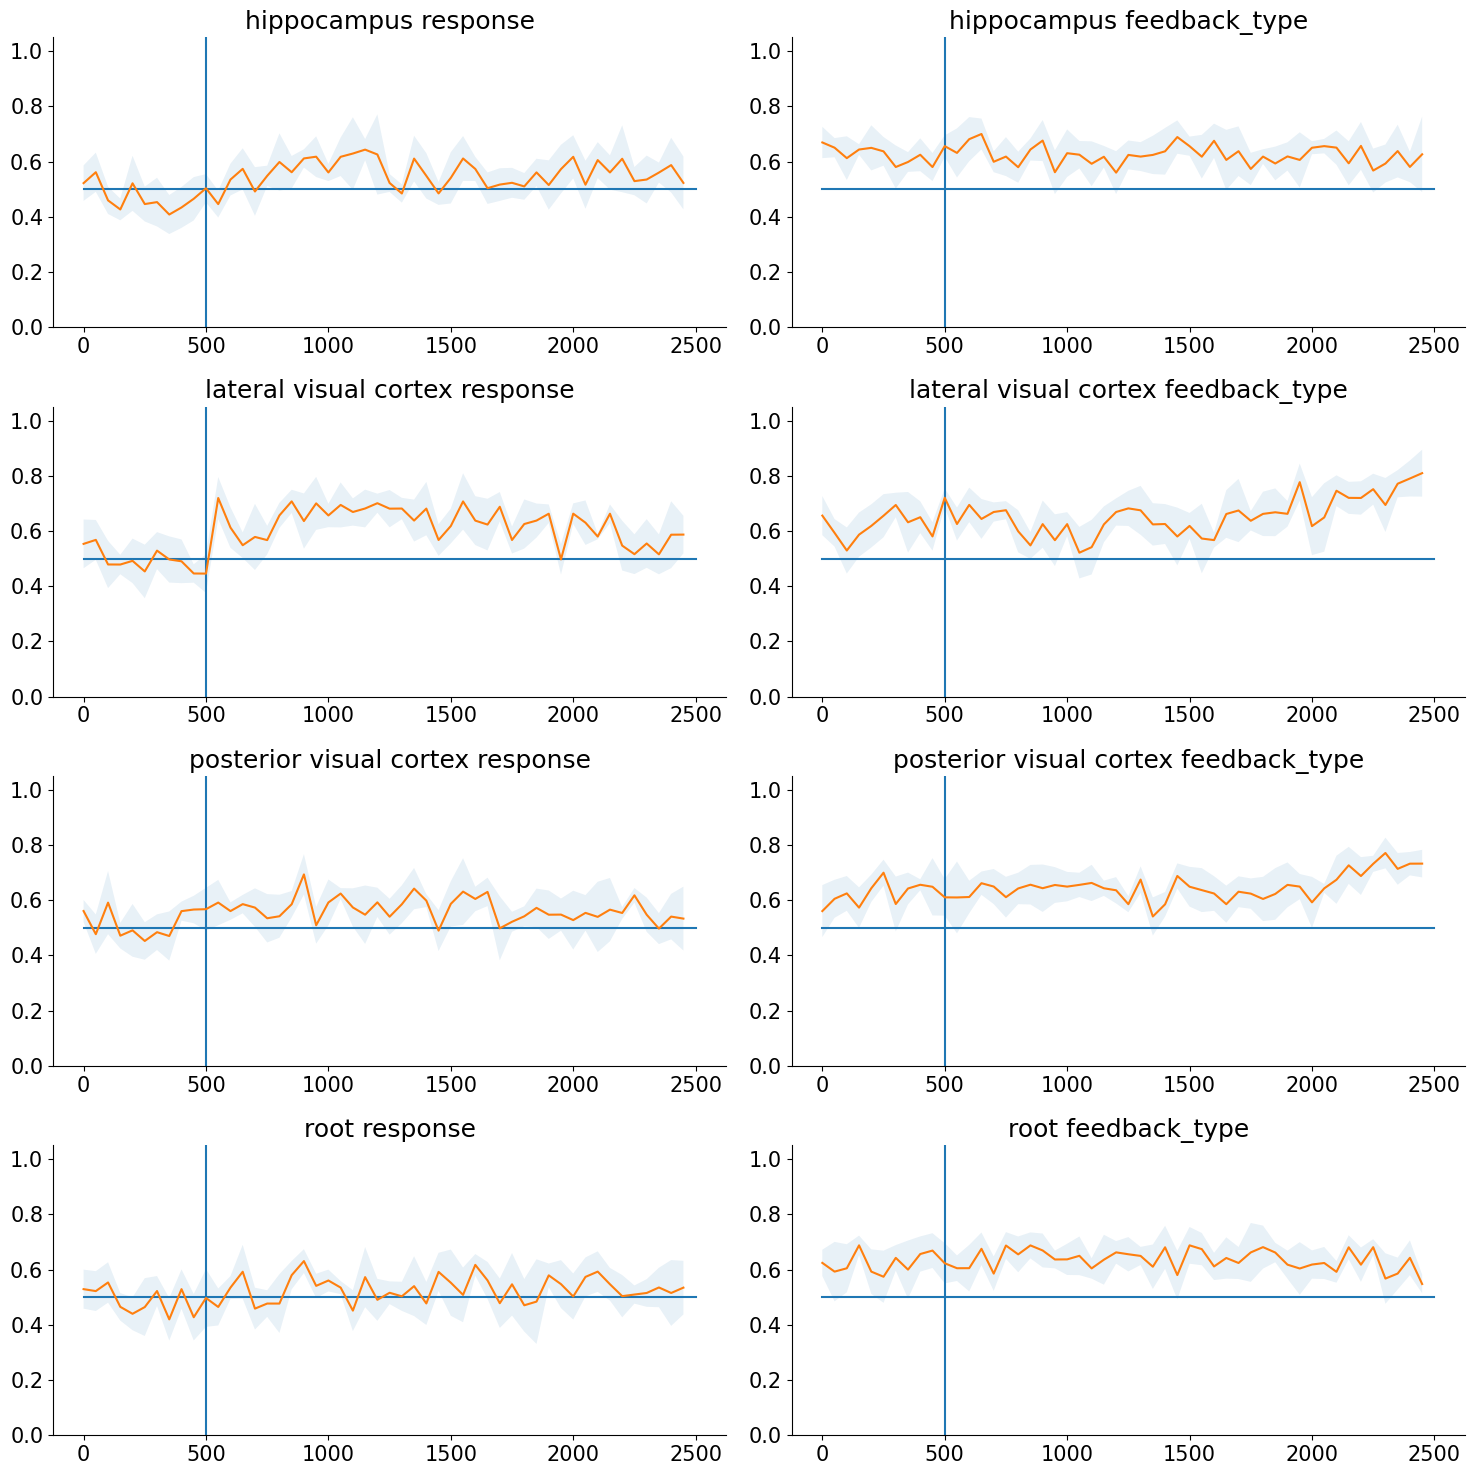

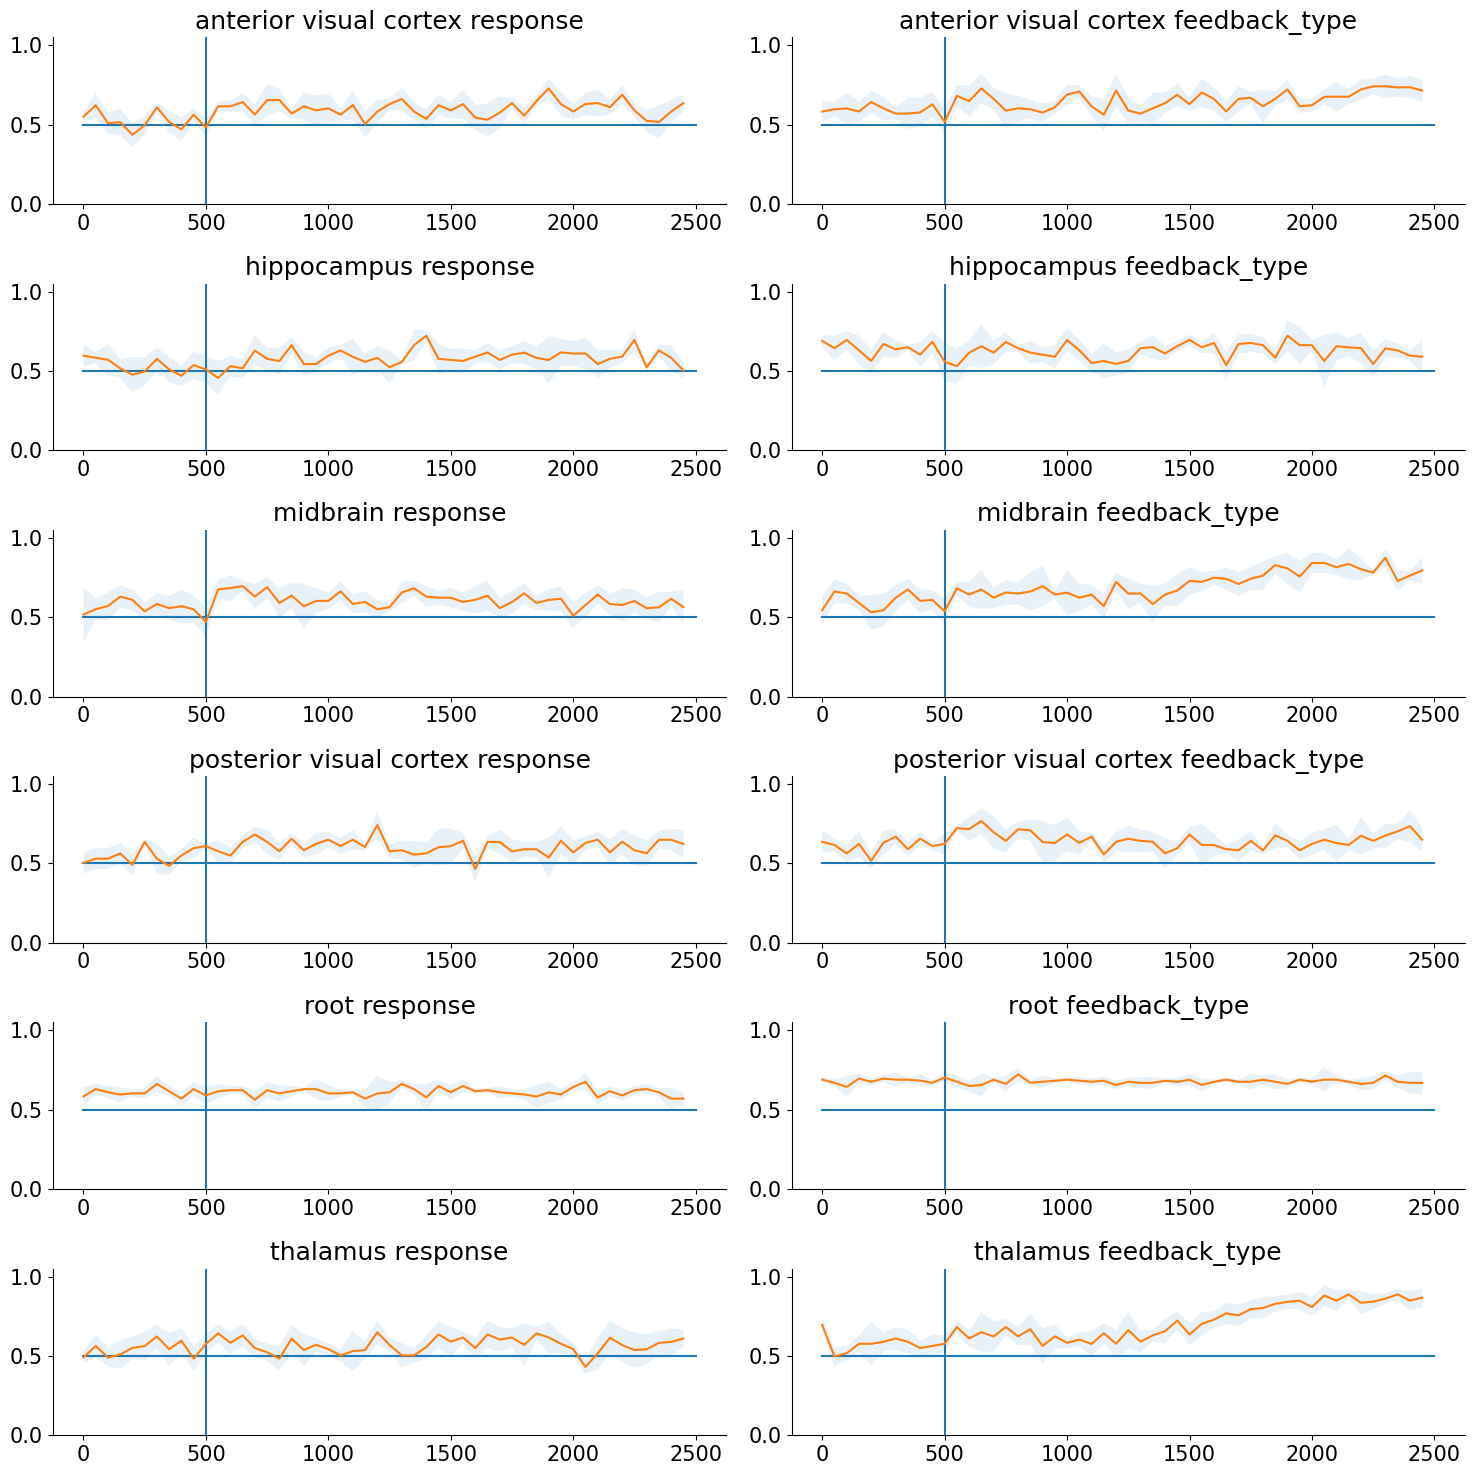

In [ ]:
##########################################################
### Decode variables from brain regions in ALL session ###
##########################################################

bin_size = 50
dt=10

# List of accuracies in different sessions
all_acc = []
all_coeffs = []

for dat in alldat[1:3]:

  # No-response filtering
  filtered_dat = trial_filter(dat, dat['response']!=0)

  # Time binning
  #rebinned_spikes = time_binning(dat['spks'],np.arange(2500),bin_size)
  rebinned_spikes = time_binning(filtered_dat['spks'],0,int(bin_size/dt))
  print('rebinned_spikes shape:', rebinned_spikes.shape)

  # Brain area merging
  filtered_dat['brain_region'] = merge_brain_areas(filtered_dat['brain_area'], new_brain_region_dict)

  # Split data along brain_areas
  print('rebinned_spikes shape:', rebinned_spikes.shape)
  spks = split_data(rebinned_spikes,filtered_dat['brain_region'])

  # Init sizes
  brain_regions = np.unique(filtered_dat['brain_region']).shape[0] # we have to change this bcs the merging/grouping -> NO.
  n_variables = len(variables)

  # Init plot
  fig, axs = plt.subplots(nrows=brain_regions, ncols=n_variables, figsize=(15,15))

  session_accuracies = {}
  session_coeffs = {}

  for cnt, brain_region in enumerate(np.unique(filtered_dat['brain_region'])):
    print(brain_region)
    print('spks[brain_region].shape', spks[brain_region].shape)
    spikes_data = spks[brain_region]

    # If spikes_data not empty decode the variables from it and save its accuracy
    if spikes_data.shape[0] != 0:
      accuracies, coefficients = decoder(axs[cnt,:], spikes_data, filtered_dat, variables, dt=bin_size, brain_area=brain_region, cv=5)
      session_accuracies[brain_region] = accuracies
      session_coeffs[brain_region] = coefficients

  all_acc.append(session_accuracies)
  all_coeffs.append(session_coeffs)

In [ ]:
# Nice new plot for decoder accuracies by brain regions

def plot_by_regions(all_accuracies):

  fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15))#figsize=(n_brain_areas * 4, n_variables * 5)

  # Create a list to store legend handles and labels
  legend_handles = []

  for region_idx, (region, brain_areas) in enumerate(brain_region_dict.items()):
    print()
    print(region_idx, region, brain_areas)
    for brain_area in brain_areas:
        if brain_area in all_accuracies:
            for var_idx, variable in enumerate(all_accuracies[brain_area]):
              print(var_idx, variable)
              region_accuracies = all_accuracies[brain_area][variable]
              plot_accuracy(axs[region_idx, var_idx], region_accuracies, dt=bin_size, name=f'{region} {variable}')

            # Add a legend handle with the brain area color
            color = axs[region_idx, var_idx].get_lines()[-1].get_color()
            legend_handles.append(mpatches.Patch(color=color, label=brain_area))

  # Add the legend with custom handles and labels
  fig.legend(handles=legend_handles, loc='center', bbox_to_anchor=(0.5, 0.03), ncol=len(legend_handles))

  plt.show()


0 visual cortex ['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']
0 response
1 feedback_type
0 response
1 feedback_type

1 thalamus ['CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM']
0 response
1 feedback_type
0 response
1 feedback_type
0 response
1 feedback_type

2 hippocampus ['CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST']
0 response
1 feedback_type
0 response
1 feedback_type
0 response
1 feedback_type

3 non-visual cortex ['ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT']
0 response
1 feedback_type
0 response
1 feedback_type
0 response
1 feedback_type

4 midbrain ['APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI']

5 basal ganglia ['ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI']

6 cortical subplate ['BLA', 'BMA', 'EP', 'EPd', 'MEA']

7 other ['other']


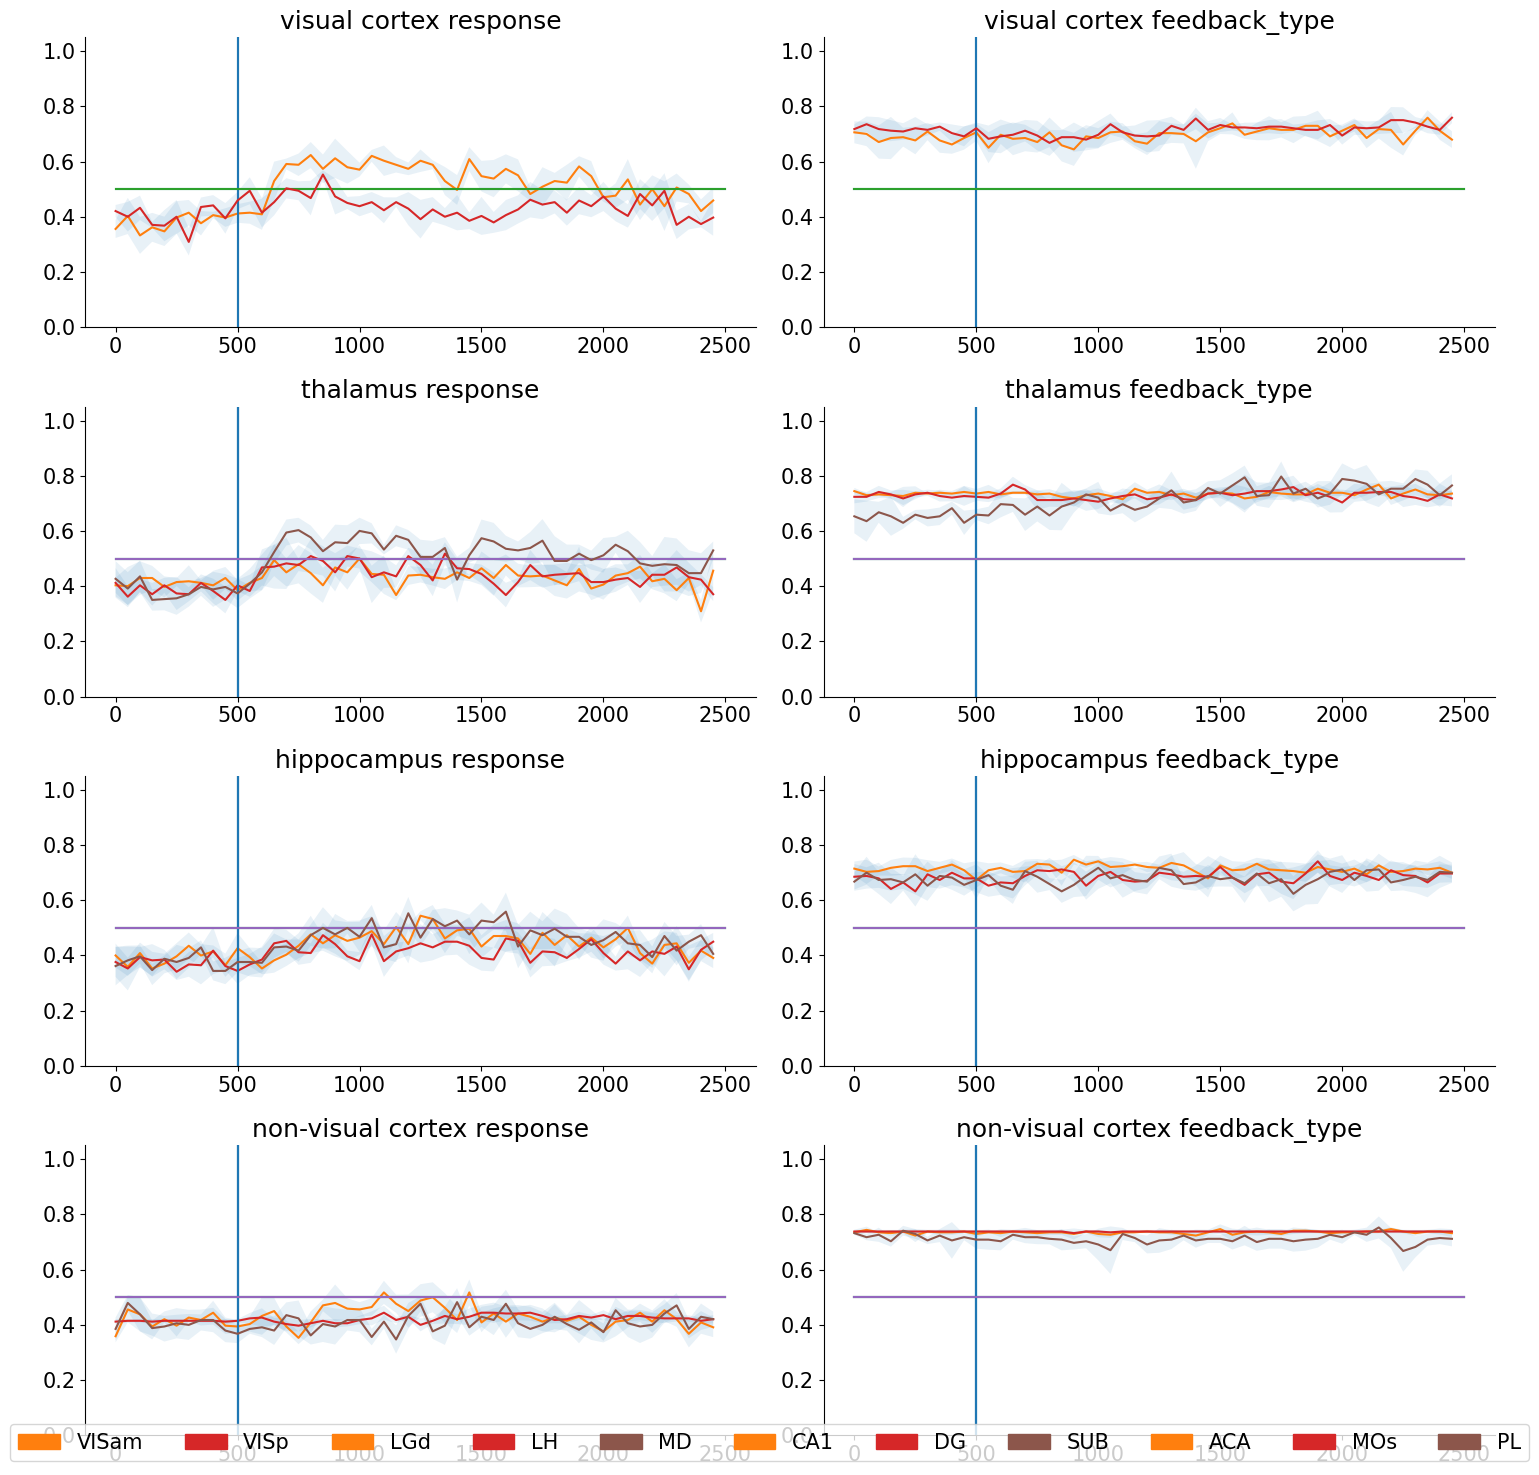

In [ ]:
# Nice new plot for decoder accuracies by brain regions

plot_by_regions(all_accuracies)

In [ ]:
def single_plot(all_accuracies_rebinned):

    fig, ax = plt.subplots(figsize=(12, 8))

    legend_handles = []

    cmap = plt.cm.get_cmap('tab20', len(all_accuracies_rebinned.keys()) * len(all_accuracies_rebinned[list(all_accuracies_rebinned.keys())[0]]))

    for region_idx, (region, brain_areas) in enumerate(brain_region_dict.items()):
        for brain_area in brain_areas:
            if brain_area in all_accuracies_rebinned:
                for var_idx, variable in enumerate(all_accuracies_rebinned[brain_area]):
                    region_accuracies = all_accuracies_rebinned[brain_area][variable]

                    # Check for NaN values in region_accuracies and remove them
                    region_accuracies = region_accuracies[~np.isnan(region_accuracies)]

                    # Combine brain area and variable to create a unique label
                    label = f'{brain_area} {variable}'

                    # Plot the accuracy data with a unique color for each brain area and variable combination
                    color = cmap(region_idx * len(all_accuracies_rebinned[brain_area]) + var_idx)
                    ax.plot(region_accuracies, label=label, color=color)

    # Add the legend with custom handles and labels outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()


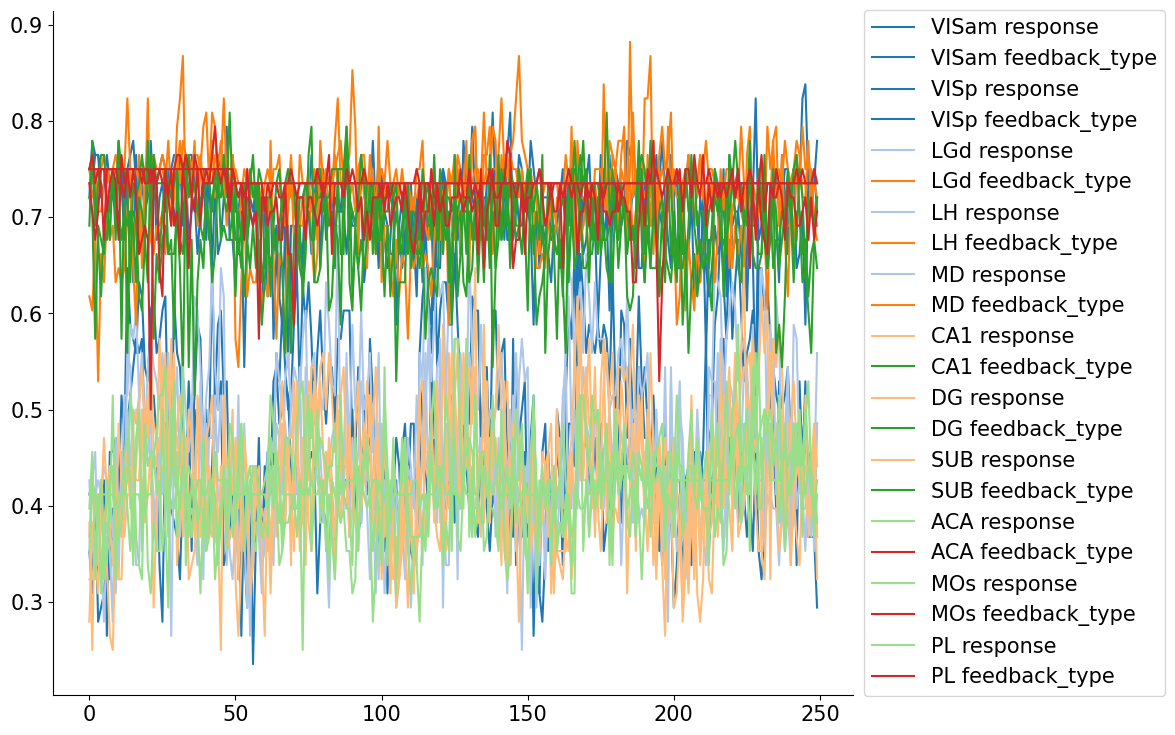

In [ ]:
single_plot(all_accuracies)

In [ ]:
#Heatmap
all_coefficients

{'ACA': {'response': array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan

# Latency analysis

\Comparative analysis (paired signed rank test) of spike frequency by time windows (X ms, **to determine**) to basal activation, from t=500ms.


In [ ]:
time_length = 2500
p_values = np.zeros((brain_areas,time_length/dt))

# Just Left Contrast

In [ ]:
'''
print(get_dat()['spks'].shape)
#print(get_dat()['brain_area'].shape)
#print(dat['contrast_right'])
#print(dat['contrast_left'])
#print(dat['contrast_left_passive'])

# Contrast right to left, pick only high contrast left. Function that if left/right>0.5, we pick it. Then choose only spikes within these trials
cons_l = (dat['contrast_left'])
cons_r = (dat['contrast_right'])
contrast_leftsum = (cons_l - cons_r)
contrast_leftsumint = 100*contrast_leftsum
c_int = contrast_leftsumint.astype(int)
#print(c_int)

results = []
for i in c_int:
        output = 0
        if i > 50:
          output = 1
        results.append(output)

just_left = np.array(results)
print(just_left.shape)


spks_only = dat['spks'][:, 0, 0]
time_only = dat['spks'][0, 0, :]
spks_left = spks_only.append(just_left)
print(spks_left.shape)

'''

NameError: ignored

# Random

In [ ]:
dat = get_dat()
where_noresponse = np.where(dat['response'] == 0)
print(where_noresponse)
print(dat['contrast_right'][where_noresponse])
print(dat['contrast_left'][where_noresponse])

In [ ]:
where_noright = np.where(dat['contrast_right'] == 0)
print(where_noright)
print(dat['response'][where_noright])

In [ ]:
# Spike data
print(dat['spks'])
print(np.shape(dat['spks']))
len(dat['spks'])


In [ ]:
dat = get_dat()

In [ ]:
dat['spks']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X, y)

print(clf.coef_)
print("")
print(clf.intercept_)

[[-0.41887908  0.96710627 -2.52093331 -1.08419917]
 [ 0.53127466 -0.31479242 -0.20020997 -0.94850676]
 [-0.11239557 -0.65231386  2.72114328  2.03270593]]

[  9.8405634    2.21733979 -12.05790319]
